In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [19]:
genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [20]:
movies = pd.read_csv('/Users/alhasan/Documents/Uneeq Interns/Movie Recommendation System/ml-100k/u.item',
                     sep='|', encoding='latin-1', header=None,
                     usecols=[0, 1] + list(range(5, 24)),
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_cols)

In [21]:
ratings = pd.read_csv('/Users/alhasan/Documents/Uneeq Interns/Movie Recommendation System/ml-100k/u.data',
                      sep='\t', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [22]:
movie_stats = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'rating_count']
movie_stats = movie_stats.reset_index()

In [23]:
# import re

# def extract_year(title):
#     match = re.search(r'\((\d{4})\)', title)
#     return int(match.group(1)) if match else None

# movies['year'] = movies['title'].apply(extract_year)

In [24]:
# Merge with movies dataset
movies = movies.merge(movie_stats, on='movie_id')
movies.head()

,movie_id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating,rating_count
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.878319,452
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.206107,131
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.033333,90
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.550239,209
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.302326,86


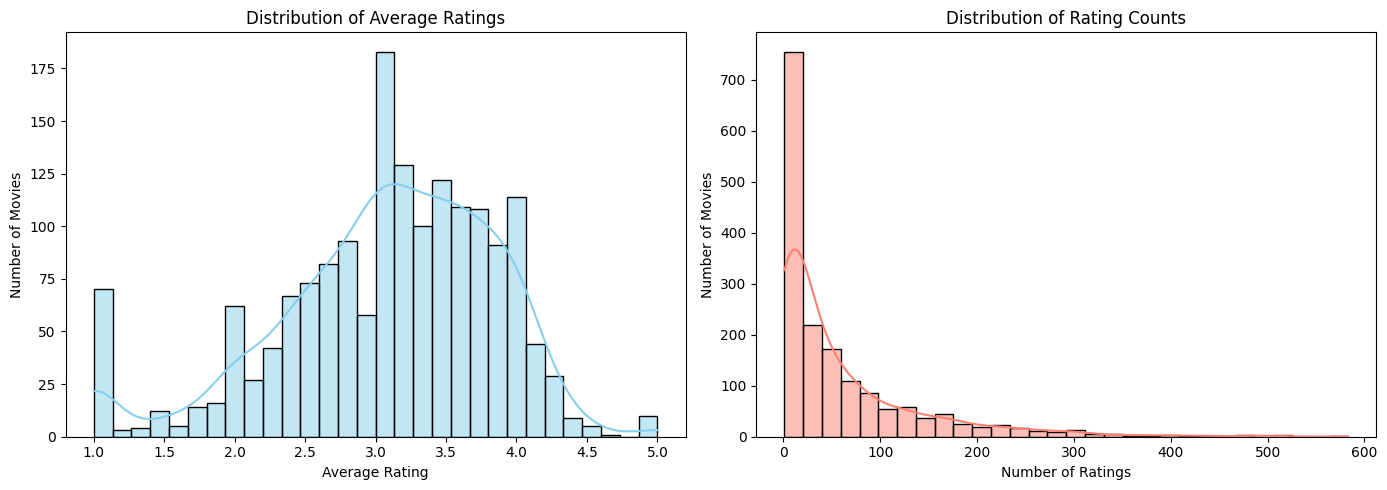

In [25]:
plt.figure(figsize=(14, 5))

# Average rating distribution
plt.subplot(1, 2, 1)
sns.histplot(movies['avg_rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')

# Rating count distribution
plt.subplot(1, 2, 2)
sns.histplot(movies['rating_count'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Rating Counts')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')

plt.tight_layout()
plt.show()

In [26]:
# Select features
features = movies[genre_cols + ['avg_rating', 'rating_count']].copy()

In [27]:
# Standardize avg_rating and rating_count (so scale doesn't dominate clustering)
scaler = StandardScaler()
features[['avg_rating', 'rating_count']] = scaler.fit_transform(features[['avg_rating', 'rating_count']])

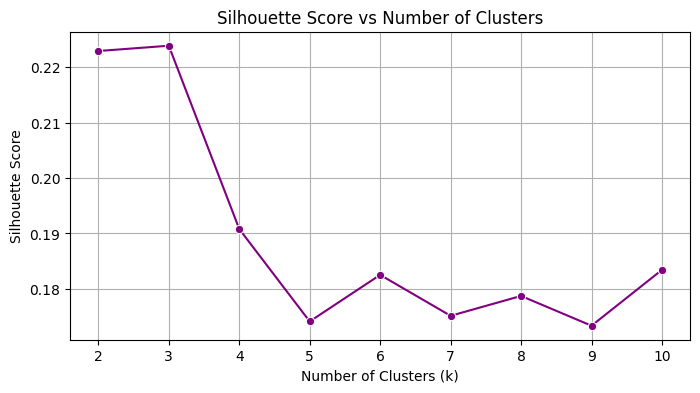

In [28]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(K_range), y=silhouette_scores, marker='o', color='purple')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [29]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(features)

movies[['title', 'avg_rating', 'rating_count', 'cluster']].head(10)

,title,avg_rating,rating_count,cluster
0,Toy Story (1995),3.878319,452,2
1,GoldenEye (1995),3.206107,131,0
2,Four Rooms (1995),3.033333,90,0
3,Get Shorty (1995),3.550239,209,2
4,Copycat (1995),3.302326,86,3
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,3.576923,26,3
6,Twelve Monkeys (1995),3.798469,392,2
7,Babe (1995),3.995434,219,2
8,Dead Man Walking (1995),3.896321,299,2
9,Richard III (1995),3.831461,89,3


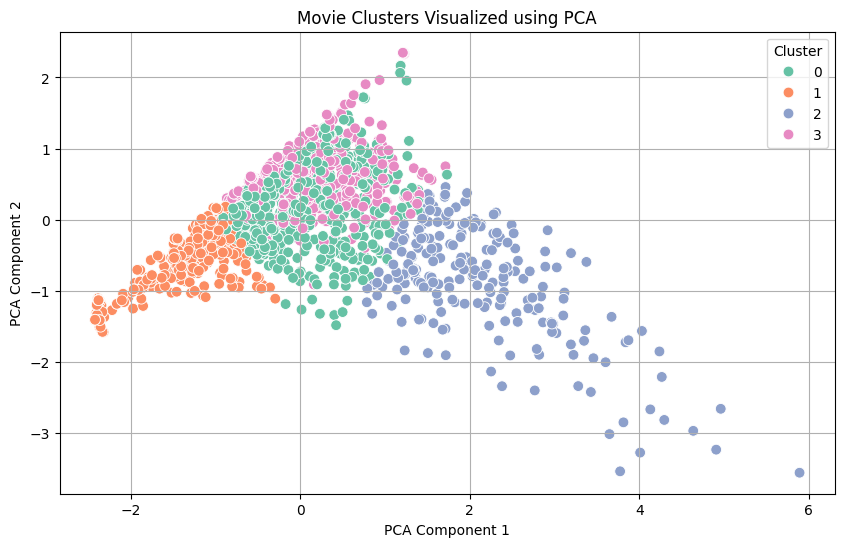

In [30]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1],
                hue=movies['cluster'], palette='Set2', s=60)
plt.title('Movie Clusters Visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [31]:
# Average features per cluster
cluster_profiles = movies.groupby('cluster')[genre_cols + ['avg_rating', 'rating_count']].mean()
cluster_profiles['num_movies'] = movies['cluster'].value_counts().sort_index()

In [32]:
# Display cluster summaries
cluster_profiles.round(2)

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating,rating_count,num_movies
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.15,0.13,0.06,0.12,0.45,0.07,0.07,0.00,0.02,...,0.06,0.05,0.16,0.09,0.18,0.02,0.03,3.28,45.12,555
1,0.0,0.17,0.06,0.01,0.09,0.33,0.05,0.03,0.33,0.02,...,0.01,0.02,0.10,0.05,0.12,0.02,0.01,1.98,11.57,396
2,0.0,0.32,0.15,0.03,0.05,0.25,0.10,0.00,0.40,0.01,...,0.06,0.06,0.22,0.14,0.29,0.14,0.02,3.74,226.80,228
3,0.0,0.05,0.01,0.00,0.02,0.13,0.06,0.00,1.00,0.00,...,0.01,0.02,0.14,0.00,0.07,0.04,0.01,3.41,37.11,503


In [33]:
import joblib

joblib.dump(kmeans, 'movie_recommender_model.pkl')


['movie_recommender_model.pkl']